Minimum viable georeferencing product. To run, change `TAG` and `VID_SOURCE_PATH` in the fourth cell to be whatever inputs you need. You will also change `VID_OUTPUT_PATH` to something appropriate. There is another byproduct, `transforms.txt`, which is a flattened 3x3 matrix that will convert a pixel coordinate into real world coordinates based on the target satellite image. The final coordinates, after all transforms are applied, are the first two divided by the third. They are easting and northing respectively. The entire program should take about 50 seconds, plus however long it takes to write the video, but usually 1 minute per 400 frames.

In [15]:
### IMPORTS AND GLOBAL FUNCTIONS

import csv
import cv2
import numpy as np
import os
import rasterio
import torch
import threading
import queue
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from models.matching import Matching
from models.futils import make_matching_plot_fast

torch.set_grad_enabled(False)

%matplotlib inline

device = 'cpu'
config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': -1
    },
    'superglue': {
        'weights': 'outdoor',
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2,
    }
}

matching = Matching(config).eval().to(device)
keys = ['keypoints', 'scores', 'descriptors']

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [16]:
### HELPER FUNCTIONS

def frame2tensor(frame, device):
    return torch.from_numpy(frame/255.).float()[None, None].to(device)

gray2 = lambda img : cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray3 = lambda img : cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

def resize_to_max_dim(img, maxdim):
    h,w,*_ = img.shape
    scale = min(maxdim/h, maxdim/w)
    newd = int(w*scale), int(h*scale)
    return cv2.resize(img, newd, cv2.INTER_AREA), scale

def rotate_nocrop(img, angle):
    h, w, *_ = img.shape
    R = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    pi = 3.141592
    TARGET_WIDTH = int(abs(w*np.cos(angle*pi/180)) + abs(h*np.sin(angle*pi/180)))
    TARGET_HEIGHT = int(abs(w*np.sin(angle*pi/180)) + abs(h*np.cos(angle*pi/180)))
    R[0,2] += TARGET_WIDTH//2 - w//2
    R[1,2] += TARGET_HEIGHT//2 - h//2
    return cv2.warpAffine(img, R, (TARGET_WIDTH, TARGET_HEIGHT)), R

def apply_transforms(pt, *ms):
    pt = np.array(pt)
    if len(pt) == 2:
        pt = np.array([*pt,1])
    elif len(pt) == 3:
        pt /= pt[2]
    else:
        raise Exception
    for m in ms:
        pt = m@pt
        pt /= pt[2]
    return pt

In [17]:
### HOMOGRAPHY AND VIDEO WRITING CLASS

class VideoWriterThread(threading.Thread):
    def __init__(self, queue, vid_out_path, fps, width, height):
        super(VideoWriterThread, self).__init__()
        self.queue = queue
        self.vid_out_path = vid_out_path
        self.fps = fps
        self.width = width
        self.height = height

    def run(self):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out_stack = cv2.VideoWriter(self.vid_out_path, fourcc, self.fps, (self.width, self.height))

        while True:
            frame = self.queue.get() # blocking, so will wait until queue not empty, return immediately on new entry
            if frame is None:
                break
            out_stack.write(frame)

        out_stack.release()


class Homographize():
    def __init__(self, im_tar, vid_in_path, vid_out_fn = None,
                 scales = None, hom_M = None, rot_M = None, ref_M = None,
                 frame_ini = 0, frame_fin = -1):

        self.vid_in_path = vid_in_path
        cwd = os.getcwd()
        if vid_out_fn == None:
            file_name = os.path.splitext(vid_in_path)[0]
            self.vid_out_path = os.path.join(cwd, file_name+'_stb.mp4')
        else:
            self.vid_out_path = os.path.join(cwd, vid_out_fn)

        self.cap = cv2.VideoCapture(self.vid_in_path)
        self.n_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.im_tar = im_tar
        self.h, self.w, _ = im_tar.shape
        
        self.scales = scales
        self.hom_M = hom_M # 3x3
        self.rot_M = rot_M # 2x3
        self.ref_M = ref_M # 3x3

        self.frame_ini = frame_ini
        if frame_fin == -1:
            self.frame_fin = self.n_frames-1
        else:
            self.frame_fin = frame_fin

        self.queue = queue.Queue()
        self.video_writer_thread = VideoWriterThread(self.queue, self.vid_out_path, self.fps, self.w, self.h)

    def run(self):
        self.video_writer_thread.start()
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.frame_ini)
        success, prev_img = self.cap.read()
        assert success == True, f"Problems reading file: {self.vid_in_path}"
        
        h_og, w_og, *_ = prev_img.shape
        h_nw, w_nw = int(h_og*self.scales[0]), int(w_og*self.scales[0])
        # these new dimensions carry over for all resizes of "prev_img"
        prev_img = cv2.resize(prev_img, (w_nw, h_nw), cv2.INTER_AREA)
        
        print('fps, n_frames, w, h: ', self.fps, self.n_frames, self.w, self.h)
        
        orb = cv2.ORB_create()
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        prev_kp, prev_des = orb.detectAndCompute(prev_img, mask=None)
        
        for i in tqdm(range(self.frame_ini,self.frame_fin)):
            success, curr_img = self.cap.read()
            if not success:
                break
            
            curr_img = cv2.resize(curr_img, (w_nw, h_nw), cv2.INTER_AREA)
            
            curr_kp, curr_des = orb.detectAndCompute(curr_img, None)
            matches = flann.knnMatch(prev_des, curr_des, k=2)

            good = []
            for p in matches:
                if len(p) > 1 and p[0].distance < 0.7*p[1].distance:
                    good.append(p[0])

            prev_pts = np.float32([ prev_kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            curr_pts = np.float32([ curr_kp[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            
            stb_M, _ = cv2.findHomography(curr_pts, prev_pts, cv2.RANSAC,5.0)
                
            curr_stabilized = cv2.warpPerspective(curr_img, self.hom_M@stb_M, (self.w, self.h))
            curr_stabilized = cv2.warpAffine(curr_stabilized, self.rot_M, (self.w, self.h), flags = cv2.WARP_INVERSE_MAP)
            # out = unrot @ tar @ est @ curr
            
            with open("transform.txt", 'a') as infile:
                t = (self.ref_M @ np.diag([1/self.scales[1], 1/self.scales[1], 1])
                     @ np.linalg.inv(np.vstack((self.rot_M, (0,0,1))))
                     @ self.hom_M @ stb_M @ np.diag([1/self.scales[0], 1/self.scales[0], 1]))
                infile.write(str(list(np.ravel(t))) + "\n")
            
            mask = (curr_stabilized != [0,0,0])
            targ = self.im_tar.copy()[:,:,2::-1]
            targ[mask] = curr_stabilized[mask]
            self.queue.put(targ)
            
            if i in (20, 80, 140, 200):
                fig, ax = plt.subplots(1,3,figsize=(24,18))
                ax[0].imshow(curr_stabilized[..., ::-1])
                ax[1].imshow(targ[:,:,::-1])
                ax[2].imshow(self.im_tar)
                

        self.queue.put(None)
        self.cap.release()

In [18]:
### IMAGE REFERENCES - img, ref, tar - 153, 180, 207, 212, 215, 220

d_img = {153: R'Problem2\153\d93b7d22_frame0.jpg', 180: R'Problem2\180\bf3a1ce7_frame0.jpg', 207: R'Problem2\207\c2377305_frame0.jpg',
         212: R'Problem2\212\867691e6_frame0.jpg', 215: R'Problem2\215\8b11db7d_frame0.jpg', 220: R'Problem2\220\ef893aa5_frame0.jpg'}
d_ref = {153: R'Problem2\153\d93b7d22_ref.tif', 180: R'Problem2\180\bf3a1ce7_ref.tif', 207: R'Problem2\207\c2377305_ref.tif',
         212: R'Problem2\212\867691e6_ref.tif', 215: R'Problem2\215\8b11db7d_ref.tif', 220: R'Problem2\220\ef893aa5_ref.tif'}
d_tar = {153: R'Problem2\153\d93b7d22_target.tif', 180: R'Problem2\180\bf3a1ce7_target.tif', 207: R'Problem2\207\c2377305_target0.tif',
         212: R'Problem2\212\867691e6_target1.tif', 215: R'Problem2\215\8b11db7d_target.tif', 220: R'Problem2\220\ef893aa5_target.tif'}

In [19]:
# PARAMETERS AND IMMUTABLES

TAG = 212
TAR_SM_DIM = 480
SRC_SM_DIM = TAR_SM_DIM
TAR_LG_DIM = 1080
SRC_LG_DIM = TAR_LG_DIM

IMG_SOURCE = cv2.imread(d_img[TAG])[:,:,::-1]
VID_SOURCE_PATH = r"vid/212NH.mp4"
VID_OUTPUT_PATH = r"vid/212_result_fiat0.mp4"

with rasterio.open(d_ref[TAG]) as dat:
    IMG_REFRNC = np.moveaxis(np.array(dat.read()),0,-1)
    REF_M = np.array(dat.transform).reshape((3,3))

with rasterio.open(d_tar[TAG]) as dat:
    IMG_TARGET = np.moveaxis(np.array(dat.read()),0,-1)
    RWC_M = np.array(dat.transform).reshape((3,3))

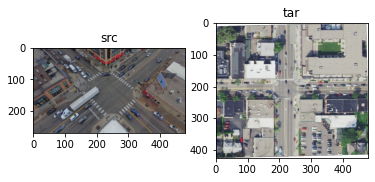

In [20]:
### SCALING AND GRAYSCALING

img_source_sm,_ = resize_to_max_dim(IMG_SOURCE, SRC_SM_DIM)
img_target_sm,_ = resize_to_max_dim(IMG_TARGET, TAR_SM_DIM)
img_source_sm_gr = gray2(img_source_sm)
img_target_sm_gr = gray2(img_target_sm)

img_source_lg,s1 = resize_to_max_dim(IMG_SOURCE, SRC_LG_DIM)
img_target_lg,s2 = resize_to_max_dim(IMG_TARGET, TAR_LG_DIM)
img_source_lg_gr = gray2(img_source_lg)
img_target_lg_gr = gray2(img_target_lg)

fig, ax = plt.subplots(1,2, figsize=(6,4))
ax[0].imshow(img_source_sm); ax[1].imshow(img_target_sm)
ax[0].set_title("src"); ax[1].set_title("tar"); 

... 3 0.6885598 0.2295199235280355
.. 7 2.7656877 0.39509824344090055
.. 99 38.90553 0.3929851416385535
.. 4 0.938662 0.23466549813747406
.. 68 23.688215 0.34835610670201916
.. 10 3.6071506 0.36071505546569826
[120, 3.8905529022216796, 0]


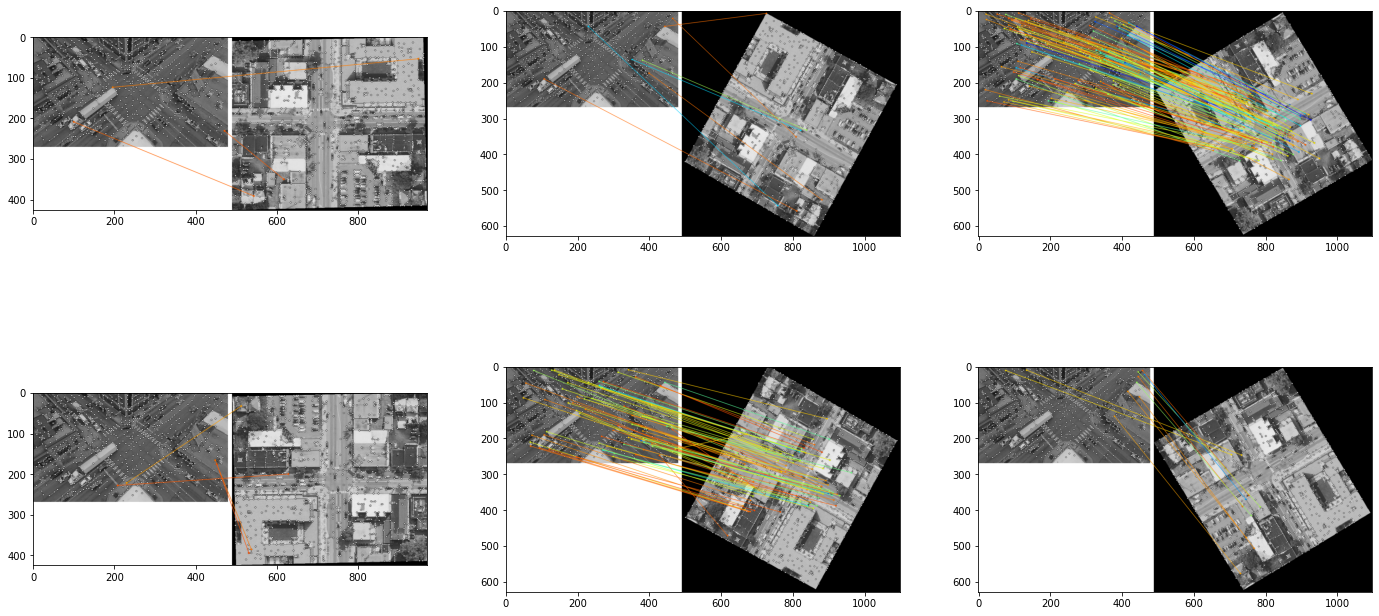

In [21]:
### ANGLE FINDING

frame_tensor = frame2tensor(img_source_sm_gr, device)
last_data = matching.superpoint({'image': frame_tensor})
last_data = {k+'0': last_data[k] for k in keys}
last_data['image0'] = frame_tensor

print(".", end="")

fig, ax = plt.subplots(2, 3, figsize=(24,12))

best = [0,0,0]

for ang in range(0, 360, 60):
    img_target_sm_gr_rot, rot_M = rotate_nocrop(img_target_sm_gr, ang)
    
    frame_tensor = frame2tensor(img_target_sm_gr_rot, device)
    pred = matching({**last_data, 'image1': frame_tensor})
    kpts0 = last_data['keypoints0'][0].cpu().numpy()
    kpts1 = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()
    confidence = pred['matching_scores0'][0].cpu().numpy()

    print(".", end="")

    valid = matches > -1
    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    color = cm.jet(confidence[valid])

    print(".", len(mkpts0), np.sum(confidence[valid]), np.sum(confidence[valid])/len(mkpts0))

    out = make_matching_plot_fast(
        img_source_sm_gr, img_target_sm_gr_rot, kpts0, kpts1, mkpts0, mkpts1, color, text=[],
        path=None, show_keypoints=True, small_text=[])

    ax[ang//180, (ang%180)//60].imshow(out)
    
    if np.sum(confidence[valid])/(1+len(mkpts0))**0.5 > best[1]:
        best[0] = ang
        best[1] = np.sum(confidence[valid])/(1+len(mkpts0))**0.5
        
print(best)

... 159


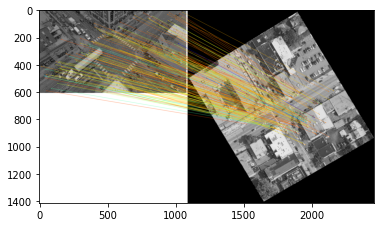

In [22]:
### USING BEST ROTATION

frame_tensor = frame2tensor(img_source_lg_gr, device)
last_data = matching.superpoint({'image': frame_tensor})
last_data = {k+'0': last_data[k] for k in keys}
last_data['image0'] = frame_tensor

print(".", end="")

img_target_lg_gr_rot, rot_M = rotate_nocrop(img_target_lg_gr, best[0])
frame_tensor = frame2tensor(img_target_lg_gr_rot, device)
pred = matching({**last_data, 'image1': frame_tensor})
kpts0 = last_data['keypoints0'][0].cpu().numpy()
kpts1 = pred['keypoints1'][0].cpu().numpy()
matches = pred['matches0'][0].cpu().numpy()
confidence = pred['matching_scores0'][0].cpu().numpy()

print(".", end="")

valid = matches > -1
mkpts0 = kpts0[valid]
mkpts1 = kpts1[matches[valid]]
color = cm.jet(confidence[valid])

print(".", len(mkpts0), end="\n")

out = make_matching_plot_fast(
    img_source_lg_gr, img_target_lg_gr_rot, kpts0, kpts1, mkpts0, mkpts1, color, text=[],
    path=None, show_keypoints=True, small_text=[])

plt.imshow(out)

Text(0.5, 1.0, 'Overlaid Image')

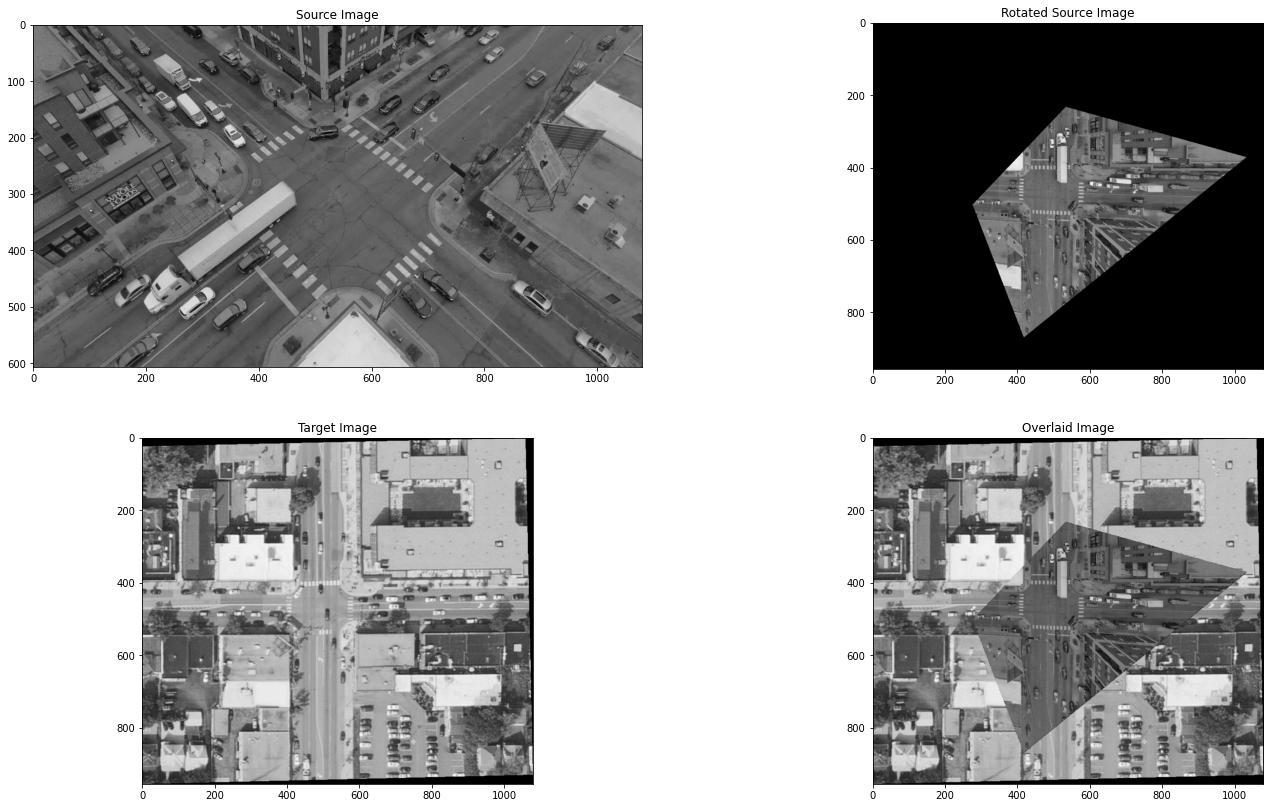

In [23]:
### CALCULATED HOMOGRAPHY

if len(mkpts0) < 10:
    raise Exception
hom_M, mask = cv2.findHomography(mkpts0, mkpts1, cv2.RANSAC, 5.0)
h,w,*_ = img_target_lg_gr_rot.shape
img_source_warp = cv2.warpPerspective(img_source_lg_gr, hom_M, (w, h))
h,w,*_ = img_target_lg_gr.shape
img_source_warp = cv2.warpAffine(img_source_warp, rot_M, (w,h), flags=cv2.WARP_INVERSE_MAP)

fig, ax = plt.subplots(2,2, figsize=(24, 14), facecolor="white")
ax[0,0].imshow(img_source_lg_gr, cmap="gray")
ax[0,0].set_title("Source Image")
ax[0,1].imshow(img_source_warp, cmap="gray")
ax[0,1].set_title("Rotated Source Image")
ax[1,0].imshow(img_target_lg_gr, cmap="gray")
ax[1,0].set_title("Target Image")
mask = (img_source_warp > 0)
img_overlay_gray = img_target_lg_gr.copy()
img_overlay_gray[mask] = img_source_warp[mask]
ax[1,1].imshow(img_overlay_gray, cmap="gray")
ax[1,1].set_title("Overlaid Image")

fps, n_frames, w, h:  30.0 1200 1080 956


100%|██████████| 40/40 [00:06<00:00,  5.90it/s]


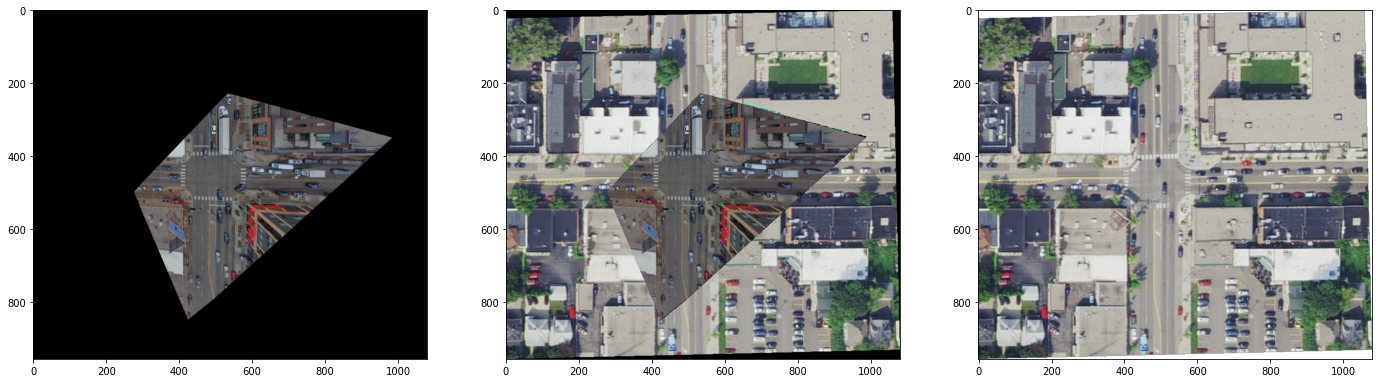

In [24]:
Homographize(img_target_lg, VID_SOURCE_PATH, VID_OUTPUT_PATH,
             [s1, s2], hom_M, rot_M, RWC_M, frame_fin=40).run()

In [25]:
### REAL WORLD COORDINATE TESTING

pts_source = []
pts_refrnc = []

with open(d_img[TAG]+".points", 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, row in enumerate(csv_reader):
        if i > 1:
            mapX, mapY = float(row[0]), float(row[1])
            sourceX, sourceY = float(row[2]), -float(row[3])

            pts_source.append([sourceX, sourceY])
            pts_refrnc.append([mapX, mapY])

            print(f"{sourceX:.2f}, {sourceY:.2f} -> {mapX:.2f}, {mapY:.2f}")
    
    pts_source, pts_refrnc = np.array(pts_source), np.array(pts_refrnc)
    
rs1_M = np.diag([s1, s1, 1])
rs2_M = np.diag([s2, s2, 1])
if rot_M.shape == (2,3):
    rot_M = np.vstack((rot_M, (0,0,1)))
else:
    rot_M = rot_M[:3,:3]

for pt,tg in zip(pts_source, pts_refrnc):
    new_pt = apply_transforms(pt, rs1_M, hom_M,
                              np.linalg.inv(rot_M),
                              np.linalg.inv(rs2_M),
                              RWC_M)
    print(np.round(new_pt[:2],2), tg, round(np.linalg.norm(new_pt[:2]-tg),3))

1418.84, 89.01 -> -10371296.93, 5613050.92
1185.74, 794.25 -> -10371325.49, 5613117.11
374.05, 971.66 -> -10371302.31, 5613155.55
1239.35, 531.48 -> -10371316.15, 5613100.51
651.98, 557.82 -> -10371291.23, 5613129.68
877.77, 295.53 -> -10371283.84, 5613103.59
[-10371297.89   5613058.73] [-10371296.92622522   5613050.91793987] 7.869
[-10371324.15   5613119.39] [-10371325.48529707   5613117.11373684] 2.64
[-10371302.37   5613154.71] [-10371302.30560166   5613155.55068856] 0.846
[-10371315.6    5613104.21] [-10371316.15304849   5613100.51008363] 3.737
[-10371291.33   5613130.41] [-10371291.23146934   5613129.68126576] 0.733
[-10371283.67   5613105.12] [-10371283.83509414   5613103.59329841] 1.54


In [26]:
a = np.array([2066.229852673459, -23947.54239738617, -10306363.83328724, -1118.579507887654, 12960.891892162004, 5578040.996445695, -0.00019924381168472178, 0.002308996482689161, 0.9937478813648165])
a.resize((3,3))

b = a@[*pts_source[0],1]
b /= b[2]
print(b)

[-10371512.15192247   5612847.64530012         1.        ]
